In [3]:
from oct2py import octave
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/bill/pymc3/")
import theano
import theano.tensor as tt
import pymc3 as pm

In [122]:
#xu = np.linspace(0,1,40)
xu = np.sort(np.random.rand(40).reshape(20,2))
x = np.sort(np.random.rand(1000))
x = np.random.rand(1000).reshape(500,2)
Ku = pm.gp.cov.ExpQuad(2, 0.2)(xu).eval()
Kx = pm.gp.cov.ExpQuad(2, 0.2)(x).eval()

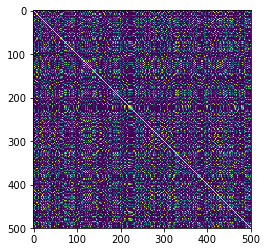

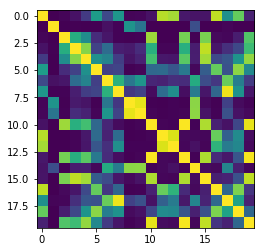

In [123]:
fig = plt.figure()
plt.imshow(Kx);

fig = plt.figure()
plt.imshow(Ku);

In [124]:
octave.push("x", x[:,None])
octave.push("xu", xu[:,None])
octave.eval(R"""
% mode 12 (equi)
function eq = equi(xg,i)                        % grid along dim i is equispaced
  xi = xg{i};
  if iscell(xi)
    eq = true; for j=1:numel(xi), eq = eq && equi(xi,j); end
  else
    ni = size(xi,1);
    if ni>1                            % diagnose if data is linearly increasing
      dev = abs(diff(xi)-ones(ni-1,1)*(xi(2,:)-xi(1,:)));
      eq = max(dev(:))<1e-9;
    else
      eq = true;
    end
  end
end


function r = isidx(i,N)     % check whether i represents an integer index vector
  r = false;
  if numel(i)>0 && ~strcmp(i,'diag') && size(i,2)==1 && ndims(i)==2
    if max(abs(i-floor(i)))<1e-13
      if 0<min(i) && max(i)<=N, r = true; end
    end
  end
end


function xf = flattengrid(xg)               % convert nested grid into flat grid
  if ~iscell(xg), xf = xg; return, end                      % catch trivial case
  xf = cell(1,0);
  for i=1:numel(xg)
    x = xg{i}; if iscell(x), xf = [xf,x]; else xf = [xf,{x}]; end
  end
end



% Robert G. Keys, Cubic Convolution Interpolation for Digital Image Processing,
% IEEE ASSP, 29:6, December 1981, p. 1153-1160.
function y = kcub(x)
  y = zeros(size(x)); x = abs(x);
  q = x<=1;          % Coefficients:  1.5, -2.5,  0, 1
  y(q) =            (( 1.5 * x(q) - 2.5) .* x(q)    ) .* x(q) + 1;
  q = 1<x & x<=2;    % Coefficients: -0.5,  2.5, -4, 2
  y(q) =            ((-0.5 * x(q) + 2.5) .* x(q) - 4) .* x(q) + 2;
end

function y = dkcub(x)
  y = sign(x); x = abs(x);
  q = x<=1;          % Coefficients:  1.5, -2.5,  0, 1
  y(q) = y(q) .*  ( 4.5 * x(q) - 5.0) .* x(q);
  q = 1<x & x<=2;    % Coefficients: -0.5,  2.5, -4, 2
  y(q) = y(q) .* ((-1.5 * x(q) + 5.0) .* x(q) - 4.0);
  y(x>2) = 0;
end



% Perform piecewise linear interpolation using inverse distance weighting.
% s (ns,1) source nodes, need neither be sorted nor equispaced
% t (nt,1) target nodes
% M (nt,ns) interpolation matrix, M = sparse((1:N)'*[1,1],J,C,nt,ns);
%
% z = M*y where y (ns,1) are source values and z (nt,1) are target values
function [J,C,dC] = neqinterp(s,t)
  ns = size(s,1); nc = 2;                                       % get dimensions
  if size(s,2)*size(t,2)~=1, error('Interpolation only possible for d==1.'), end
  if ns<nc, error('Interpolation only possible for ns>=nc.'), end
  [s,ord] = sort(s); ds = diff(s); 
  if min(ds)<1e-10, error('Some source points are equal.'), end
  [junk,ii] = histc(t(:),[-inf;s(2:end-1);inf]);
  d0 = t(:)-s(ii); d1 = s(ii+1)-t(:); d0n = d0<0; d1n = d1<0;
  d0(d0n) = 0; d1(d1n) = 0;                                % boundary conditions
  J = [ord(ii),ord(ii+1)]; C = [d1./(d1+d0),d0./(d1+d0)];
  nz = 1-(d1n|d0n); if nargout>2, dC = [-nz./(d1+d0),nz./(d1+d0)]; end
end



% Compute interpolation coefficients C (nt,nc) and interpolation coefficient
% indices J (nt,nc) from a source grid s (ns,1) to a target array t (nt,1).
% The coefficient matrix C has rows summing up to 1.
function [J,C,dC] = eqinterp(s,t,d)
  gp = false;
  switch d
    case 0, k = @(x) -0.5<x & x<=0.5; it=-1:0; dk = @(x) 0*x;
    case 1, k = @(x) max(1-abs(x),0); it=-1:0; dk = @(x) -(abs(x)<=1).*sign(x);
    case 3, k = @kcub;                it=-2:1; dk = @dkcub;
    otherwise, ell = d/5; gp = true;                          % GP interpolation
      k = @(x) exp(-x.*x/(2*ell^2));  it=(0:d-1)-floor(d/2);
      dk = @(x) -k(x).*x/(ell^2);
  end
  ds = s(2)-s(1); ns = numel(s); nt = numel(t); nc = numel(it);
  if size(s,2)*size(t,2)~=1, error('Interpolation only possible for d==1.'), end
  if ns<nc, error('Interpolation only possible for ns>%d.',nc-1), end
  j = floor((t-s(1))/ds)+1;                % index of closest smaller grid point
  w = (t-s(1))/ds-j+1;   % relative distance to closest smaller grid point [0,1]
  j = j-it(nc); C = zeros(nt,nc); dC = zeros(nt,nc);
  for i=1:nc
    C(:,i) = k(w+it(nc+1-i)); if nargout>2, dC(:,i)=dk(w+it(nc+1-i))*(ns-1); end
  end
  if gp, kn = k(sqrt(sq_dist(1:d))); C = C/kn; dC = dC/kn; end
  v = 1; id = find(j<nc+it(1)); C(id,:) = 0; dC(id,:) = 0;  % fix lower boundary
  D = abs(repmat(s(1:nc)',numel(id),1)-repmat(t(id),[1,nc]));
  [junk,jid] = min(D,[],2);          % index of closest index in boundary region
  for i=1:numel(id), C(id(i),jid(i)) = 1; dC(id(i),jid(i)) = 0; end, j(id) = v;
  v = ns-nc+1; id = find(j>v); C(id,:) = 0; dC(id,:) = 0;   % fix upper boundary
  D = abs(repmat(s(ns-nc+1:ns)',numel(id),1)-repmat(t(id),[1,nc]));
  [junk,jid] = min(D,[],2);          % index of closest index in boundary region
  for i=1:numel(id), C(id(i),jid(i)) = 1; dC(id(i),jid(i)) = 0; end, j(id) = v;
  J = zeros(nt,nc); for i=1:nc, J(:,i) = j+i-1; end    % construct index array J
end


% mode 6 (interp)
% deg, degree of equispaced interpolation polynomial, 0:nn, 1:lin, 3:cub
function [Mx,dMx] = interpgrid(xg,x,deg)
  %xg = flattengrid(xg);                                      % remove nestedness
  p = numel(xg); Dg = zeros(p,1); ng = zeros(p,1); n = size(x,1);      % dims ..
  for i=1:p, [ng(i),Dg(i)] = size(xg{i}); end, N = prod(ng);       %.. and sizes
  ix = isidx(x,N);             % determine whether x is an index or a data array
  if ix
    Mx = sparse(1:n,x,1,n,N); if nargout>1, dMx = repmat({sparse(n,N)},p,1); end
  else
    if nargin<3, deg = 3; end, deg = deg(:).*ones(p,1);       % cubic is default
    s = 1;                                                      % initial stride
    for i=1:p                                 % iterate over Toeplitz components
      d = sum(Dg(1:i-1))+(1:Dg(i));                     % dimensions of interest
      xt = xg{i}; it = find(abs(xt(2,:)-xt(1,:)));        % grid nonzero inc idx
      if equi(xg,i)                         % compute interpolation coefficients
        if nargout>1                                       % equispaced grid pts
          [Ji,Ci,dCi] = eqinterp(xt(:,it),x(:,d(it)),deg(i));
        else
          [Ji,Ci] = eqinterp(xt(:,it),x(:,d(it)),deg(i));
        end
      else
        if nargout>1   % non-equispaced grid pts, lin interp, inv dist weighting
          [Ji,Ci,dCi] = neqinterp(xt(:,it),x(:,d(it)));
        else
          [Ji,Ci] = neqinterp(xt(:,it),x(:,d(it)));
        end
      end
      nc = size(Ci,2);    % number of interpolation coefficients along dimension
      if i==1
        C = Ci; J = ones(n,1);
        if nargout>1, dC = repmat({Ci},p,1); dC{1} = dCi; end
      else
        C = repmat(C,[1,1,nc]) .* repmat(reshape(Ci,n,1,nc),[1,size(C,2),1]);
        C = reshape(C,n,[]);
        if nargout>1
          for j=1:p
            if i==j, dCij = dCi; else dCij = Ci; end
            dC{j} = repmat(dC{j},[1,1,nc]) .* ...
                    repmat(reshape(dCij,n,1,nc),[1,size(dC{j},2),1]);
            dC{j} = reshape(dC{j},n,[]);
          end
        end
      end
      J = repmat(J(:),[1,nc]) + s*repmat(Ji-1,[size(C,2)/nc,1]);  % blow 2nd idx
      s = s*ng(i);                                               % update stride
    end
    I = repmat((1:n)',[1,size(C,2)]); id = 0<J&J<=N;% first index and valid flag
    Mx = sparse(I(id),J(id),C(id),n,N);
    if nargout>1
      dMx = cell(p,1); for i=1:p,dMx{i} = sparse(I(id),J(id),dC{i}(id),n,N); end
    end
  end
end



[Mx,dMx] = interpgrid({xu},x,1);  
""")
Mx = octave.pull("Mx")
Mx = Mx.todense()
print(Mx.todense())
print(Mx.shape, Ku.shape, Mx.T.shape, Kx.shape)
print(np.dot(Mx, Ku).shape)

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



Oct2PyError: Octave evaluation error:
error: Interpolation only possible for d==1.
error: called from:
    neqinterp at line 3, column 30
    interpgrid at line 22, column 22

31.7939408833


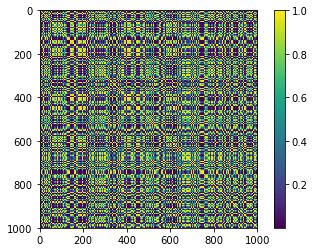

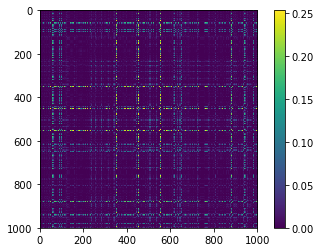

In [118]:
Km = np.dot(np.dot(Mx, Ku), Mx.T)
print(np.linalg.norm(Km - Kx))
plt.figure()
m=plt.imshow(Km); plt.colorbar(m)

plt.figure()
m=plt.imshow(np.abs(Kx - Km)); plt.colorbar(m)


In [119]:
Mx[0:10,0:10]

matrix([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.72581978,  0.27418022,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.69753371],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.       

31.7939408833


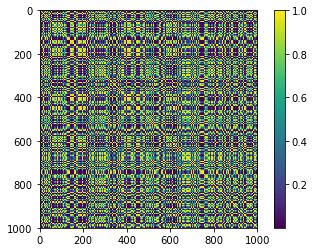

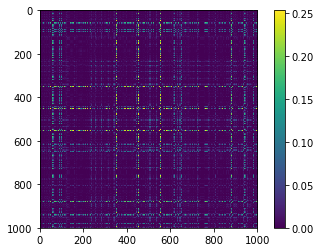

In [120]:
Km = np.dot(np.dot(Mx, Ku), Mx.T)
print(np.linalg.norm(Km - Kx))
plt.figure()
m=plt.imshow(Km); plt.colorbar(m)

plt.figure()
m=plt.imshow(np.abs(Kx - Km)); plt.colorbar(m)
